In [1]:
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.signal import butter, filtfilt,detrend
import numpy as np
from numpy.polynomial import legendre as leg
from numpy.linalg import lstsq
import datetime
from datetime import timedelta
import pandas as pd
import geopy.distance
from shapely.geometry import LineString
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.core import Trace
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
from obspy.signal.trigger import classic_sta_lta,recursive_sta_lta
from obspy.signal.trigger import plot_trigger
import scipy
from scipy.fft import fft, ifft

In [51]:
#Function that returns the DAS data according to USGS earthquake events

def das_downloader(this_id, cab='seadasn'):
    this_event = event_df[event_df.id==this_id]
    t0 = this_event['time'].iloc[0]

    cable = cab
    record_length = 1 #minutes
    
    try:
        if cable == 'seadasn':
            prefix = 'seadasn'
            network_name = 'SeaDAS-N'
            if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
                datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
            elif t0 > datetime.datetime(2022, 6, 20, 0, 0, 0) and t0 < datetime.datetime(2022, 10, 6, 0, 0, 0):
                datastore='/data/data7/seadasn_2022-06-21_2022-10-06/'
            elif t0 > datetime.datetime(2022, 11, 1, 0, 0, 0) and t0 < datetime.datetime(2022, 11, 5, 0, 0, 0):
                datastore='/data/data4/seadasn_2021-11-01_2021-11-05/'
            elif t0 > datetime.datetime(2022, 10, 13, 0, 0, 0) and t0 < datetime.datetime(2022, 11, 1, 0, 0, 0):
                datastore='/data/data1/seadasn_2021-10-13_2021-11-01/'

        elif cable == 'whidbey':
            prefix = 'whidbey'
            network_name='Whidbey-DAS'
            datastore = '/data/data5/Converted/'

        data,times,attrs = open_sintela_file(prefix,
                                             t0,
                                             datastore,
                                             number_of_files=record_length,
                                             verbose=True)
        x_max=data.shape[1] * attrs['SpatialSamplingInterval']
        
        low_cut = 3
        hi_cut = 8
        
        b,a = butter(2,[low_cut,hi_cut],'bp',fs=attrs['MaximumFrequency']*2,output='sos')
        data_filt = filtfilt(b,a,data,axis=0)
    
    except Exception as e:
        print(f'caught {type(e)}: e')
        data = None
        dates = None
        attrs = None
        x_max = None
        data_filt = None
    return data, times, attrs, x_max, this_id, data_filt, t0

In [3]:
# # Get a list of events from USGS and load events (specify search radius)
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=100, 
                latitude=47.60, 
                longitude=-122.33)



#Get list of USGS events
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)

#Create a list with the event id numbers for data download
event_df = event_df[(event_df['depth'] > 2.0) & (event_df['magnitude'] > 3.0)]
culled = len(events)-len(event_df)
earthquake_list = event_df['id'].values.tolist()
print("Found %s events" % len(events),"and culled %s"%culled, "events due to depth and Mw constraints")
event_df

Found 759 events and culled 755 events due to depth and Mw constraints


,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
474,uw61869652,2022-09-08 08:08:25.830,"7 km WNW of Lofall, Washington",47.842000,-122.751667,23.33,3.71,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,592
116,uw61835766,2022-05-01 11:15:56.460,"2 km E of Mount Vernon, Washington",48.423500,-122.305500,13.54,3.56,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,424
167,uw61832097,2022-05-17 08:07:34.400,"6 km ENE of Oso, Washington",48.299667,-121.852000,3.53,3.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,280
383,uw61860022,2022-08-04 13:22:39.400,"6 km SSE of Black Diamond, Washington",47.258667,-121.971833,21.54,3.06,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,250


/data/data5/Converted/whidbey_2022-09-08_08-08*.h5


<IPython.core.display.Javascript object>


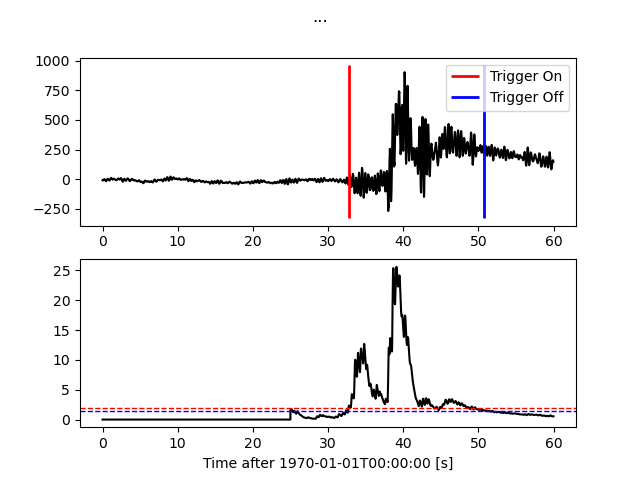

uw61869652


In [66]:
arrival_picks = {}
das_quake_attrs = {}

for i in earthquake_list[:1]:
    
    data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(i,cab='whidbey')
    
    
    if attrs != None:  
#         if attrs['NumberOfLoci'] == 1721:
            das_quake_attrs[this_id] = attrs
            if  x_max != None:
                travel_times = []
                chan_number = 0
                for channel in data_filt.T[:500,:]:
                    das_trace = Trace(channel)
                    das_trace.stats['sampling_rate'] = attrs['PulseRate']
                    df = das_trace.stats.sampling_rate
                    cft = recursive_sta_lta(das_trace, int(0.5 * df), int(25 * df))
                    travel_times.append(  (cft.argmax() / attrs['PulseRate'] - (t0 - times[0] ).total_seconds() ))
                    chan_number +=1
                plot_trigger(das_trace, cft,2.0,1.5)
                
            # Now do correction on raw picks using Legendre polynomial fitting with outliers
            deg=1
            xs = np.r_[0:len(travel_times)]
            V = leg.legvander(xs,deg)
            coeffs = lstsq(V,np.array(travel_times),rcond=None)[0]
            g = leg.legval(xs,coeffs)
            arrival_picks[str(i)] = g
            print(this_id)
        
            
# for i in earthquake_list:
    
#     data, dates, attrs, x_max, this_id, data_filt, t0 = das_downloader(i,cab='seadasn')
    
    
#     if attrs != None:  
#         if attrs['NumberOfLoci'] == 4556:
#             das_quake_attrs[this_id] = attrs
#             if  x_max != None:
#                 channel_picks = []
#                 chan_number = 0
#                 for channel in data_filt.T:
#                     das_trace = obspy.core.trace.Trace(channel)
#                     das_trace.stats['sampling_rate'] = attrs['PulseRate']
#                     df = das_trace.stats.sampling_rate
#                     cft = recursive_sta_lta(das_trace, int(0.5 * df), int(20 * df))
#                     channel_picks.append(  (cft.argmax() / attrs['PulseRate'] - (t0 - dates[0] ).total_seconds() ))
#                     chan_number +=1
#             plot_trigger(das_trace, cft,2.5,0.75)
#             arrival_picks[str(i)] = channel_picks
#             print(this_id)

In [37]:
attrs['NumberOfLoci']

1721

<IPython.core.display.Javascript object>


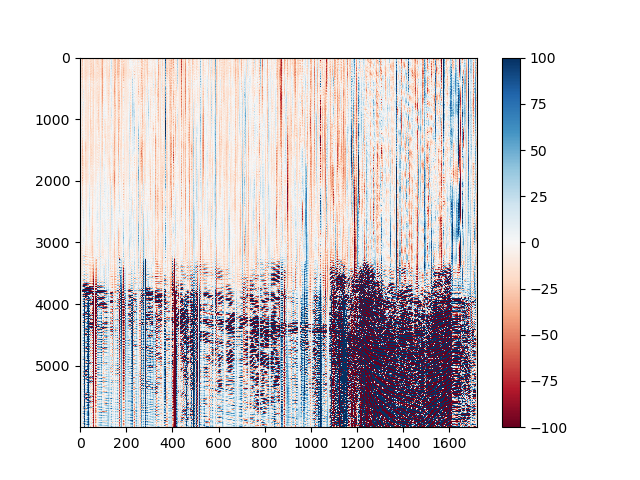

In [61]:
plt.figure()
plt.imshow(data_filt,aspect='auto',vmin=-100,vmax=100,cmap='RdBu')
plt.colorbar()

<IPython.core.display.Javascript object>


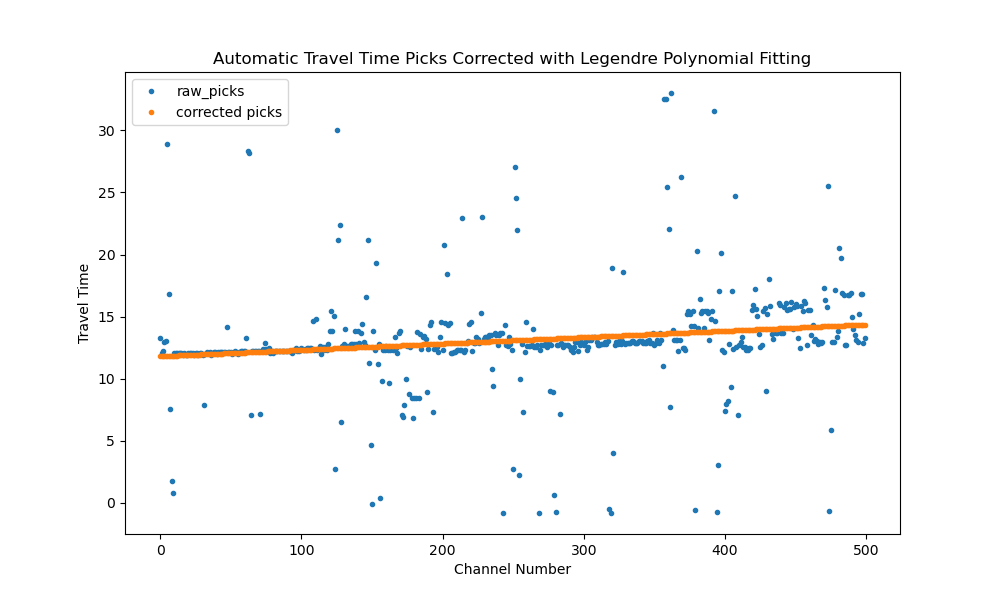

In [83]:
plt.figure(figsize=(10,6))
plt.plot(travel_times,'.',label='raw_picks')
plt.plot(g,'.',label='corrected picks')
plt.xlabel('Channel Number')
plt.ylabel('Travel Time')
plt.title('Automatic Travel Time Picks Corrected with Legendre Polynomial Fitting')
plt.legend(loc='upper left')

#### Routine for interpolating the channel location based off the calibration and fiberroute files.

In [71]:
import geopy.distance
from shapely.geometry import LineString

#For sintela fiberroute and calibration files
def fiber_channel_locator(fiber_file = 'fiberroute.csv', cal_file='calibration.csv', chan_spac = 6.3, num_chans = 1750):
    fiber_location = pd.read_csv(fiber_file, header=1)
    fiber_calibration = pd.read_csv(cal_file, header=1)
    fiber_distance = []
    opt_dis_merge = []
    chan_num = []

    for index_fib, row_fib in fiber_location.iterrows():
        if index_fib == 0 :
            fiber_distance.append(0)
        elif index_fib > 0:
            coords_1 = (row_fib['Lat'], row_fib['Long'])
            coords_2 = (fiber_location.iloc[index_fib-1]['Lat'], fiber_location.iloc[index_fib-1]['Long'])
            distance = geopy.distance.geodesic(coords_1, coords_2).m
            fiber_distance.append(distance   + fiber_distance[-1])

        l = []
        for index_cal, row_cal in fiber_calibration.iterrows():
            if row_fib['Lat'] == row_cal['Lat'] and row_fib['Long'] == row_cal['Long']:
                l.append(row_cal['Opt Dist'])
            else:
                pass
        if l:
            opt_dis_merge.append(l[0])
        else:
            opt_dis_merge.append(np.nan)

    fiber_location['Fiber Dist'] = fiber_distance
    fiber_location['Opt Dist'] = opt_dis_merge
    dis_interp = fiber_location['Opt Dist'].interpolate(method='linear', fill_value='extrapolate')
    fiber_location['Opt Dist Interp'] = dis_interp
    
    for index_merge, row_merge in fiber_location.iterrows():
        if row_merge['Opt Dist Interp'] != np.nan:
            
            chan_num.append(row_merge['Opt Dist Interp'] / chan_spac)
            
    fiber_location['Chan Num Interp'] = chan_num
    
    coords_of_chans_x = []
    coords_of_chans_y = []


    for index, values in fiber_location.iterrows():
        if index < len(fiber_location) - 1:
            #print(values['Lat'], fiber_location.iloc[index+1]['Lat'])
            xy_floats = [(fiber_location.iloc[index]['Long'], fiber_location.iloc[index]['Lat']),
                         (fiber_location.iloc[index+1]['Long'], fiber_location.iloc[index+1]['Lat'])]
            line = LineString(xy_floats)
            num_points = int(round((fiber_location.iloc[index+1]['Opt Dist Interp'] - values['Opt Dist Interp']) / attrs['SpatialSamplingInterval']))
            new_points = [line.interpolate(i/float(num_points - 1), normalized=True) for i in range(num_points)]
            xs = [point.x for point in new_points]
            ys = [point.y for point in new_points]
            coords_of_chans_x.append(xs)
            coords_of_chans_y.append(ys)

    flat_x =  [item for sublist in coords_of_chans_x for item in sublist]
    flat_y =  [item for sublist in coords_of_chans_y for item in sublist]
    
    return fiber_location, fiber_calibration, flat_x, flat_y

In [74]:
num_chans = attrs['NumberOfLoci']
chan_spac = attrs['SpatialSamplingInterval']

fiber_location,fiber_calibration, flat_x, flat_y = fiber_channel_locator(chan_spac = chan_spac, num_chans = num_chans)

arr_of_chan = np.linspace(1, num_chans, num_chans)
last_point = (num_chans * chan_spac) - (chan_spac / 2)
arr_opt_dist = np.linspace(chan_spac / 2, last_point , num_chans)

<IPython.core.display.Javascript object>


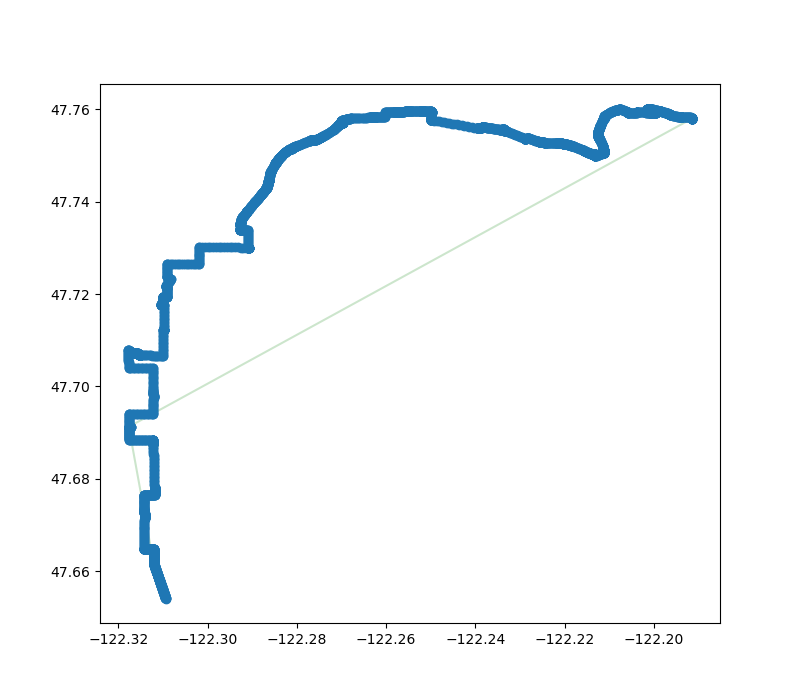

In [75]:
#Plot the channel locations
fig, ax = plt.subplots(figsize = (8,7))
ax.plot(fiber_location['Long'], fiber_location['Lat'], zorder=1, alpha= 0.2, c='b')
ax.plot(fiber_calibration['Long'], fiber_calibration['Lat'], zorder=1, alpha= 0.2, c='g')
ax.scatter(flat_x, flat_y)